To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)



## Acknowledgements

Currently, the implementation does not support vLLM or video inputs.

This notebook was contributed by [Sinoué GAD](https://github.com/GAD-cell). Happy to support the community :)

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.8.5.post1

In [ ]:
#@title Colab Extra Install (execute only in Colab) { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    #added for this specific notebook
    !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124
    !pip install --no-deps -U transformers==4.52.4
    !pip install --no-deps -U accelerate
    !pip install --no-deps trl==0.18.2

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

The objective of this notebook is to fine-tune a VLM (`Qwen2.5VL 3B`) on a dataset and subsequently train it using GRPO for image-based reasoning tasks.

In [61]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = False, # True or "unsloth" for long context
)


model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = lora_rank,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = lora_rank,  # Recommended alpha == r at least
    lora_dropout = 0.1,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)


==((====))==  Unsloth 2025.6.3: Fast Qwen2_5_Vl patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.495 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

# Dataset

We are using the dataset Clevr_CoGenT_TrainA_R1 from [R1-V](https://github.com/Deep-Agent/R1-V?tab=readme-ov-file) which consists of image pairs containing multiple objects, along with reasoning questions based on spatial and semantic relationships between those objects.


In [ ]:
from datasets import load_dataset
from PIL import Image
dataset = load_dataset('MMInstruction/Clevr_CoGenT_TrainA_R1',split='train')
print(dataset)

Dataset({
    features: ['image', 'thinking', 'problem', 'solution'],
    num_rows: 37773
})


Let's visualize a sample from the dataset

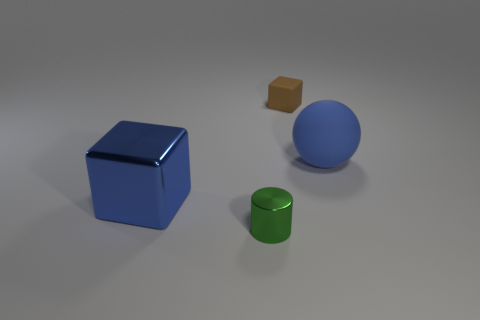

What number of purple metallic balls are there?
<think>
Okay, let's look at the problem. The user is asking about the number of purple metallic balls in the described scene. 

First, I need to go through each object in the image to check their attributes. The objects listed are:

1. A large blue rubber sphere.
2. A small brown rubber cube.
3. A small green metal cylinder.
4. A large blue metal cube.

Each object has details about color, material, shape, rotation, coordinates, etc. The key attributes here are color ("purple"), material ("metallic"), and shape ("ball" or sphere). 

Looking at each object:

- The first is a sphere, which is a ball shape, but it's blue and made of rubber. So color and material don't match.
- The second is a cube, so shape doesn't match. Also, it's brown and rubber.
- Third is a cylinder, so shape is not a ball. It's green and metal, so color is wrong.
- Fourth is a cube again, shape not matching. It's blue and metal, so color is incorrect.

None of the obj

In [40]:
sample = dataset[0]
display(sample['image'])
print(sample["problem"])
print(f"{sample['thinking']}{sample['solution']}")

# Prepare dataset for SFT

The dataset is already well-formatted, so we only need to apply the fine-tuning template. The format_sample function will then be passed to the **UnslothVisionDataCollator**.




In [ ]:
reasoning_start = "<think>"
reasoning_end   = "</think>"
solution_start  = "<answer>"
solution_end    = "</answer>"

def format_sample(sample):
  content = [
      {"type":"image","image":sample['image']},
      {"type":"text","text":f"{sample['problem']}"}
      ]


  return {
      "messages": [
           {"role":"system",
            "content": f"""You are given a problem with an image.
            Think about the problem and provide your working out.
            Place it between {reasoning_start} and {reasoning_end}.
            Then, provide your solution between {solution_start}{solution_end}"""},
          {
              "role": "user",
              "content": content
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": f"{sample['thinking']}{sample['solution']}"}
              ]
          }
      ]
  }

Let's now pre fine-tune the model so it follows our custom GRPO formatting!


In [ ]:
from unsloth import is_bf16_supported
from trl import SFTTrainer, SFTConfig
from unsloth.trainer import UnslothVisionDataCollator


FastVisionModel.for_training(model) # Enable for training!
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model,tokenizer,formatting_func=format_sample), # Notice the formatting_func
    train_dataset = dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        max_steps = 150,
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 2, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    )
)



Unsloth: Model does not have a default image size - using 512


In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 37,773 | Num Epochs = 1 | Total steps = 150
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 82,169,856/3,000,000,000 (2.74% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
5,2.080000
10,1.519800
15,1.281600
20,1.119500
25,0.807800
30,0.947200
35,0.996400
40,1.039300
45,0.830200
50,0.812000


TrainOutput(global_step=150, training_loss=0.9111059761047363, metrics={'train_runtime': 190.2769, 'train_samples_per_second': 0.788, 'train_steps_per_second': 0.788, 'total_flos': 2806047248793600.0, 'train_loss': 0.9111059761047363})

Let's see if the fine tuning worked by generating a sample

In [ ]:
sample = dataset[0]

message = [
        {"role":"system",
        "content": f"""You are given a problem with an image.
            Think about the problem and provide your working out.
            Place it between {reasoning_start} and {reasoning_end}.
            Then, provide your solution between {solution_start}{solution_end}"""
      },
      {"role": "user",
       "content": [
        {"type": "image"},
        {"type":"text","text":f"{sample['problem']}"},
        ]}]

image =sample['image']

input_text = tokenizer.apply_chat_template(message, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")


from transformers import TextStreamer
_ = model.generate(
    **inputs,
    temperature = 0.1,
    max_new_tokens = 1024,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)

<|im_start|>system
You are given a problem with an image.
            Think about the problem and provide your working out.
            Place it between <think> and </think>.
            Then, provide your solution between <answer></answer><|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><

Looks like it works fine!

We'll define regex patterns to extract both the expected output format and the model's response, which will be used for reward attribution.

In [ ]:
import re

# Add optional EOS token matching
solution_end_regex = f"{re.escape(solution_end)}[\\s]*" + \
    f"(?:{re.escape(tokenizer.eos_token)})?"

match_format = re.compile(
    rf"{re.escape(reasoning_end)}.*?" \
    rf"{re.escape(solution_start)}(.+?){solution_end_regex}" \
    r"[\s]*$",
    flags=re.MULTILINE | re.DOTALL
)
solution = re.compile(r"<answer>\s*(.*?)\s*</answer>", flags=re.DOTALL)


Let's test the regex patterns we've defined.


In [ ]:
response = "<think>blabla alz grlfrfffze</think><answer> 0 </answer>"

match = solution.search(response)
if match:
    print("Extracted answer:", match.group(1))
else:
    print("No match found.")

Extracted answer: 0


Looks like it works fine!


# Reward functions

We won’t go into much detail on the reward part here. For further information, please refer to the [Qwen3_(4B)-GRPO](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Qwen3_(4B)-GRPO.ipynb#scrollTo=9HJxrS76h3Ds) notebook.

In [ ]:
def check_answer_exactly(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]

    responses = [completion[0]["content"] for completion in completions]
    extracted_responses = [
        guess.group(1)
        if (guess := solution.search(r)) is not None else None
        for r in responses
    ]
    scores = []
    print(f"predicted:{extracted_responses[0]}")
    print(f"groundtruth:{answer[0]}")
    for guess, true_answer in zip(extracted_responses, answer):
        true_answer = true_answer[0]
        true_answer = solution.search(true_answer).group(1)
        score = 0
        if guess is None:
            scores.append(-2.0)
            continue

        if guess == true_answer:
            score += 5.0
        elif guess.strip() == true_answer.strip():
            score += 3.5

        else:
          score -= 4
        scores.append(score)
    return scores



def match_format_approximately(completions, **kwargs):
    scores = []
    print(completions[0][0]["content"])
    for completion in completions:
        score = 0
        response = completion[0]["content"]

        score += 0.5 if response.count(reasoning_start) == 1 else -1.0
        score += 0.5 if response.count(reasoning_end)   == 1 else -1.0
        score += 0.5 if response.count(solution_start)  == 1 else -1.0
        score += 0.5 if response.count(solution_end)    == 1 else -1.0
        scores.append(score)
    return scores

def match_format_exactly(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Match if format is seen exactly!
        if match_format.search(response) is not None: score += 2.0
        scores.append(score)
    return scores


# Format the dataset

Here, I’m using a class to format the dataset on the fly during training. This approach is especially useful for image datasets, since offline formatting can be time-consuming and memory-intensive. Additionally, it lets you apply image transformations dynamically.
Alternatively, you can format the dataset offline using a simple lambda function.

In [ ]:
def format_sample_GRPO(sample):
  content = [
      {"type":"image"},
      {"type":"text","text":f"{sample['problem']}"}
      ]

  return {
      "prompt": [
          {"role":"system",
           "content":f"""You are given a problem.
            Think about the problem and provide your working out.
            Place it between {reasoning_start} and {reasoning_end}.
            Then, provide your solution between {solution_start}{solution_end}"""
           },
          {
              "role": "user",
              "content": content
          },],
      "image": [sample['image']],
      "answer": [sample['solution']]
  }

from torch.utils.data import Dataset
class LazyFormattedDataset(Dataset): #This class will format the dataset on the fly during training
    def __init__(self, dataset, format_fn):
        super().__init__()
        self.dataset = dataset
        self.format_fn = format_fn

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return self.format_fn(item)

    def __len__(self):
        return len(self.dataset)

dataset_grpo=LazyFormattedDataset(dataset=dataset,format_fn=format_sample_GRPO) #The final dataset



# GRPO Config

Here is the interesting part, you just have to set ``use_vision = True`` in GRPOConfig to enable VLM GRPO.

Note that I lowered max_completion_length in order to reduce the reasoning trace and lower the training time.

We use TensorBoard to monitor training progress. You can launch TensorBoard in another notebook, connect to the same environment, and run the following commands: \\
`%load_ext tensorboard` \\
`%tensorboard --logdir logs `

In [ ]:
from unsloth import is_bf16_supported
from trl import GRPOConfig,GRPOTrainer

logging_dir="./logs"
run = "run_V1"
log_path=f"{logging_dir}/{run}"

FastVisionModel.for_training(model)
training_args = GRPOConfig(
    use_vision = True, # Enable VLM GRPO
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    beta=0.005, # KL regularization, decrease to encourage model exploration
    temperature=1,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    bf16 = is_bf16_supported(),
    fp16 = not is_bf16_supported(),
    num_iterations = 1,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = 1024,
    max_completion_length = 256,
    #num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 250,
    save_steps = 50,
    max_grad_norm = 0.1,
    output_dir="./results",
    logging_dir=log_path,
    logging_strategy="steps",
    logging_steps=1,
    report_to="tensorboard", #can use W&B
)

trainer = GRPOTrainer(
    model = model,
    processing_class=tokenizer,
    reward_funcs = [
        match_format_exactly,
        match_format_approximately,
        check_answer_exactly,
    ],
    args = training_args,
    train_dataset = dataset_grpo,
)

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 37,773 | Num Epochs = 1 | Total steps = 250
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 82,169,856/3,000,000,000 (2.74% trained)


<think>
Okay, let's see. The question is asking how many blue objects have the same shape as the red rubber sphere. First, I need to identify all the objects in the scene that are blue and then check if their shape matches the red rubber sphere.

Looking at the image, there are several objects listed. Let me go through each one:

1. A large gray metal cube: This is a cube, not a sphere. So this doesn't count.
2. A small purple rubber cylinder: Cylinder, so not a sphere. So no.
3. A large cyan rubber cylinder: Cylinder again, so no.
4. A small brown rubber sphere: Sphere, but it's brown, not red. So this is different.
5. A large yellow metal sphere: Sphere, but color is yellow, not red. So no.
6. A small gray metal cube: Cube, so not a sphere. Not relevant.
7. A small purple rubber cylinder: Cylinder, not a sphere. So no.
8. A large purple metal cylinder: Cylinder, not a sphere. So no.
9. A small gray rubber cylinder: Cylinder, not a sphere. So no.
10. A large red rubber sphere: This is

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / match_format_exactly / mean,rewards / match_format_exactly / std,rewards / match_format_approximately / mean,rewards / match_format_approximately / std,rewards / check_answer_exactly / mean,rewards / check_answer_exactly / std
1,0.003000,-4.312500,0.375000,256.000000,256.000000,256.000000,1.000000,0.000000,0.000000,0.000000,0.609415,0.000000,0.000000,-2.312500,0.750000,-2.000000,0.000000
2,0.004000,-3.656250,1.687500,255.750000,252.000000,256.000000,0.937500,252.000000,252.000000,252.000000,0.578934,0.125000,0.500000,-2.218750,1.125000,-1.562500,1.750000
3,0.052100,2.250000,3.375000,218.312500,163.000000,256.000000,0.125000,212.928574,163.000000,242.000000,0.764969,1.750000,0.683130,1.437500,1.537043,-0.937500,4.186785
4,0.014800,-3.375000,1.125000,251.375000,229.000000,256.000000,0.750000,237.500000,229.000000,246.000000,0.779151,0.500000,0.894427,-1.375000,2.012461,-2.500000,0.894427
5,0.014700,-3.656250,0.562500,247.562500,182.000000,256.000000,0.812500,211.000000,182.000000,247.000000,0.706059,0.375000,0.806226,-1.656250,1.814008,-2.375000,0.806226
6,0.022200,1.125000,6.090990,233.000000,179.000000,256.000000,0.437500,215.111115,179.000000,248.000000,0.746998,1.250000,1.000000,0.312500,2.250000,-0.437500,3.881044
7,0.015000,-3.656250,1.687500,253.625000,218.000000,256.000000,0.937500,218.000000,218.000000,218.000000,0.582624,0.125000,0.500000,-2.218750,1.125000,-1.562500,1.750000
8,0.017200,-0.843750,2.714632,236.750000,165.000000,256.000000,0.562500,212.000015,165.000000,252.000000,0.781848,0.875000,1.024695,-0.531250,2.305564,-1.187500,3.187868
9,0.003100,-4.500000,0.000000,256.000000,256.000000,256.000000,1.000000,0.000000,0.000000,0.000000,0.628220,0.000000,0.000000,-2.500000,0.000000,-2.000000,0.000000
10,0.008400,-2.531250,2.511057,253.687500,237.000000,256.000000,0.812500,243.666672,237.000000,256.000000,0.631167,0.375000,0.806226,-1.656250,1.814008,-1.250000,2.489980


<think>
Okay, let's see. The question is asking how many other objects share the same material as the brown cube. First, I need to identify the material of the brown object mentioned in the scene.

Looking at the image provided, there are three objects: a large yellow metal sphere, a small purple rubber sphere, and a small brown metal cube. The question refers to the "brown thing," which corresponds to the third object listed: the small brown metal cube. 

Now, I need to check if any other objects have the same material. Let me go through each object one by one:

1. The first object is a large yellow metal sphere. Its material is metal. Since the brown object is also made of metal, this counts as one match.
2. The second object is a small purple rubber sphere. The material here is rubber, so that doesn given object does not match.
3. The third object is a small brown metal cube. This is the one we're comparing against. Since its material is metal, it matches the brown object.

So, the 

KeyboardInterrupt: 

You can now save the LoRa weights

In [ ]:
model.save_pretrained("vlmgrpo_save")  # Local saving
tokenizer.save_pretrained("vlmgrpo_save")

[]

Now let's test the result by taking a sample image from the dataset.



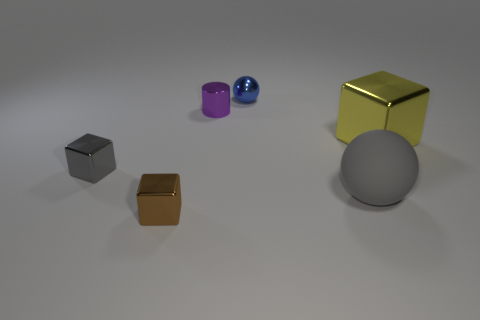

In [42]:
image = dataset[10000]['image']
display(image)

Ok let's ask how many other objects are the same size as the grey sphere (answer : 1)

In [59]:
question = 'How many other objects are the same size as the grey sphere?'

message = [
        {"role":"system",
        "content": f"""You are given a problem with an image.
            Think about the problem and provide your working out.
            Place it between {reasoning_start} and {reasoning_end}.
            Then, provide your solution between {solution_start}{solution_end}"""
      },
      {"role": "user",
       "content": [
        {"type": "image"},
        {"type":"text","text":question},
        ]}]


input_text = tokenizer.apply_chat_template(message, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")


from transformers import TextStreamer
_ = model.generate(
    **inputs,
    temperature = 0.5,
    max_new_tokens = 1024,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)





<|im_start|>system
You are given a problem with an image.
            Think about the problem and provide your working out.
            Place it between <think> and </think>.
            Then, provide your solution between <answer></answer><|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><

Let's try an inference with the LoRa adpaters disabled to compare

In [60]:
from transformers import TextStreamer
with model.disable_adapter():
  _ = model.generate(
      **inputs,
      temperature = 0.1,
      max_new_tokens = 1024,
      streamer = TextStreamer(tokenizer, skip_prompt = False),
  )

<|im_start|>system
You are given a problem with an image.
            Think about the problem and provide your working out.
            Place it between <think> and </think>.
            Then, provide your solution between <answer></answer><|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><

We can observe that the GRPO-trained VLM produces answers that are significantly more detailed and precise compared to the model without GRPO training — although it mistakenly counted the gray sphere along with the yellow cube.

In contrast, the baseline inference fails to properly address the task and makes several incorrect assertions regarding relative sizes — for example, claiming that "the brown cube is larger than the gray cube," which is not true.

Notes:

  -In some cases, the reference model can actually provide better answers, particularly for very simple questions where a straightforward response suffices, whereas the GRPO-trained model might get lost in unnecessary reasoning.

  -Training could be further improved by incorporating more visually grounded rewards — for example, by requiring the model to output bounding boxes (BBOX) of the regions of interest — but this would require a fine-grained annotated dataset.

  -We could also enhance performance by training for more steps (currently only 200) and allowing longer input sequences, though this would significantly increase training time.




### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )



And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>